In [167]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json

# Nome do bairro, cidade e país
place_name = "L'Esquerra de l'Eixample, Barcelona, Spain"

# Obter o grafo apenas para o bairro desejado
G = ox.graph_from_place(place_name, network_type="drive")

In [168]:
# Função para determinar a região de um nó com base em coordenadas
def determinar_regiao(x, y, centro, matriz_rotacao):
    novo_x, novo_y = np.dot(matriz_rotacao, [x - centro[0], y - centro[1]])
    if novo_x >= 0 and novo_y > 0:
        return "nordeste"
    elif novo_x < 0 and novo_y > 0:
        return "noroeste"
    elif novo_x >= 0 and novo_y <= 0:
        return "sudeste"
    elif novo_x < 0 and novo_y <= 0:
        return "sudoeste"

dict_regiao = {"nordeste": 102,
               "noroeste": 203,
               "sudeste": 305,
               "sudoeste": 404}
# Coordenadas do centro e ângulo para a matriz de rotação
centro = (2.1573688, 41.3881816)
theta = -np.pi / 3  # Ajuste o ângulo para dividir as regiões
matriz_rotacao = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)],
])

# Mapear os nós para índices numéricos consecutivos
node_to_index = {node: idx for idx, node in enumerate(G.nodes)}
# Ajustar classificação de segmentos para evitar regiões de transição
segmentos = []
id_counter = 0

for u, v, data in G.edges(data=True):
    x0, y0 = G.nodes[u]["x"], G.nodes[u]["y"]
    x1, y1 = G.nodes[v]["x"], G.nodes[v]["y"]

    # Determinar região do nó de saída
    regiao = determinar_regiao(x0, y0, centro, matriz_rotacao)

    # Adicionar segmento de ida (usando apenas a região do nó de saída)
    segmento_ida = {
        "id": id_counter,
        "vSaida": node_to_index[u],
        "vEntrada": node_to_index[v],
        "imoveis": [],
        "limVel": data.get("maxspeed", "N/A"),
        "tamanho": int(data.get("length", 0)),
        "rua": f"{data.get('name', f'Rua desconhecida {id_counter}')}_{regiao}",
        "regiao": regiao,
        "CEP": dict_regiao[regiao]
    }
    id_counter += 1
    segmentos.append(segmento_ida)

    # Adicionar segmento de volta, se a rua não for mão única
    if not data.get("oneway", False):
        regiao_volta = determinar_regiao(x1, y1, centro, matriz_rotacao)  # Região do nó de entrada
        segmento_volta = {
            "id": id_counter,
            "vSaida": node_to_index[v],
            "vEntrada": node_to_index[u],
            "imoveis": [],
            "limVel": data.get("maxspeed", "N/A"),
            "tamanho": int(data.get("length", 0)),
            "rua": f"{data.get('name', f'Rua desconhecida {id_counter}')}_{regiao_volta}",
            "regiao": regiao_volta,
        }
        id_counter += 1
        segmentos.append(segmento_volta)


# Criar lista de adjacência
num_vertices = len(node_to_index)
listaAdj = [[] for _ in range(num_vertices)]
for segmento in segmentos:
    listaAdj[segmento["vSaida"]].append(segmento)

print(listaAdj)


[[{'id': 0, 'vSaida': 0, 'vEntrada': 1, 'imoveis': [], 'limVel': '50', 'tamanho': 132, 'rua': 'Gran Via de les Corts Catalanes_sudoeste', 'regiao': 'sudoeste', 'CEP': 404}, {'id': 1, 'vSaida': 0, 'vEntrada': 34, 'imoveis': [], 'limVel': '50', 'tamanho': 150, 'rua': 'Carrer de Casanova_sudoeste', 'regiao': 'sudoeste', 'CEP': 404}], [{'id': 2, 'vSaida': 1, 'vEntrada': 75, 'imoveis': [], 'limVel': '50', 'tamanho': 19, 'rua': 'Carrer de Muntaner_sudoeste', 'regiao': 'sudoeste', 'CEP': 404}, {'id': 3, 'vSaida': 1, 'vEntrada': 105, 'imoveis': [], 'limVel': '50', 'tamanho': 134, 'rua': 'Gran Via de les Corts Catalanes_sudoeste', 'regiao': 'sudoeste', 'CEP': 404}], [{'id': 4, 'vSaida': 2, 'vEntrada': 3, 'imoveis': [], 'limVel': '50', 'tamanho': 137, 'rua': 'Carrer de París_noroeste', 'regiao': 'noroeste', 'CEP': 203}, {'id': 5, 'vSaida': 2, 'vEntrada': 49, 'imoveis': [], 'limVel': '50', 'tamanho': 130, 'rua': 'Carrer de Villarroel_noroeste', 'regiao': 'noroeste', 'CEP': 203}], [{'id': 6, 'vSai

In [169]:
# Colete todos os nomes de ruas únicos
nomes = set()

for segmento in segmentos:
    nome_rua = segmento["rua"]
    if isinstance(nome_rua, list):
        nome_rua = nome_rua[0]  # Converte a lista em uma string concatenada
        segmento["rua"] = nome_rua
    nomes.add(nome_rua)

# Conte a quantidade de nomes únicos
quantidade_ruas_diferentes = len(nomes)

# Exiba o resultado
quantidade_ruas_diferentes


64

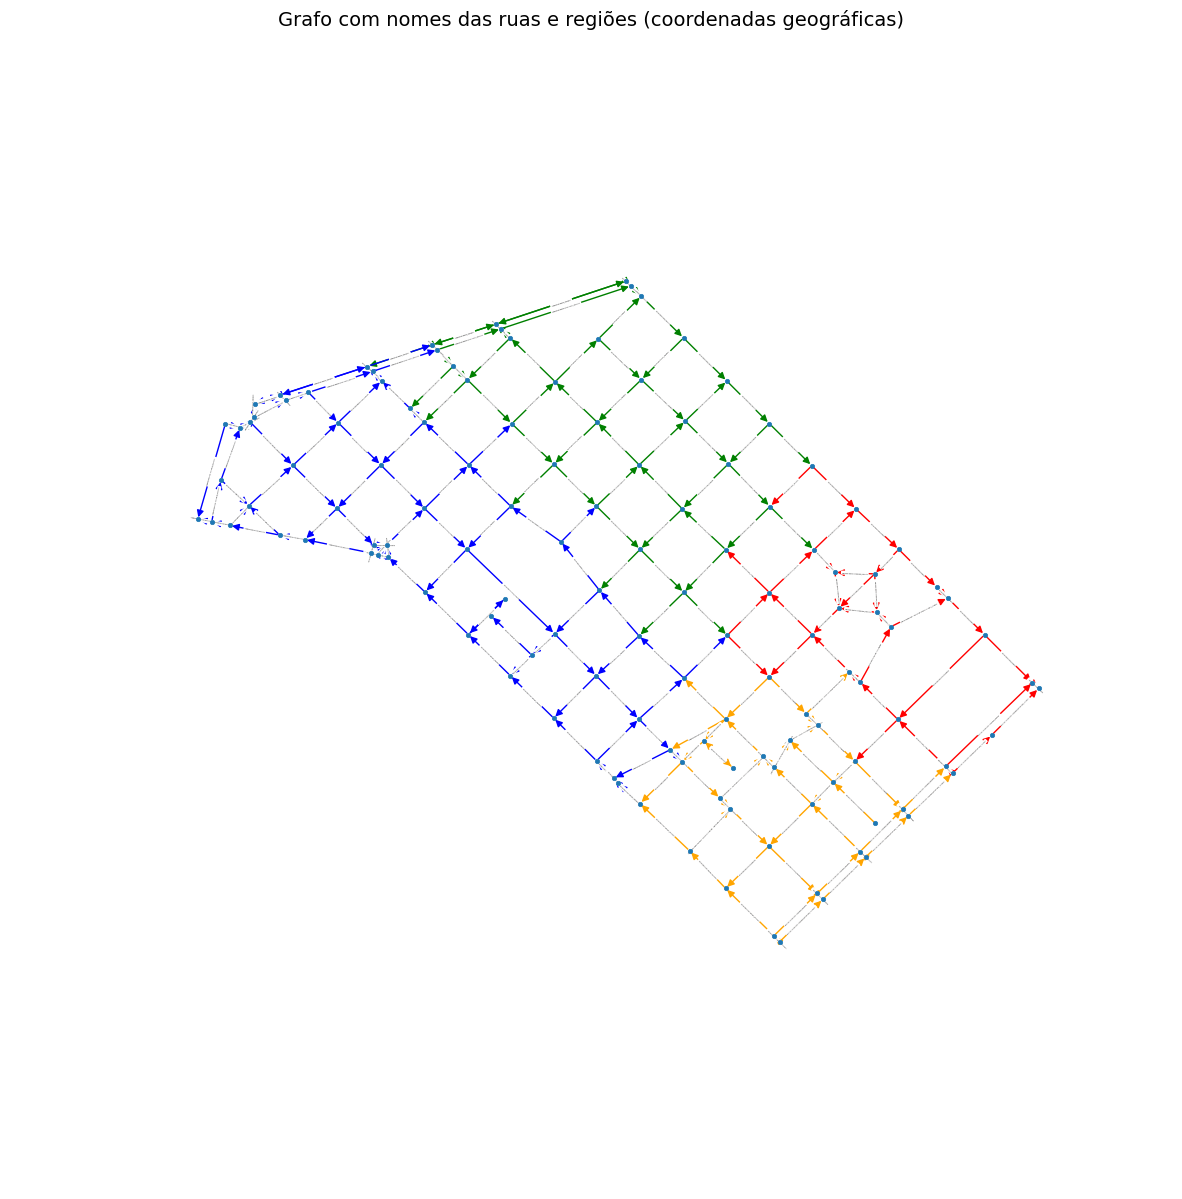

In [170]:
import matplotlib.pyplot as plt
import networkx as nx

# Define as cores das regiões
cores_regioes = {
    "noroeste": "blue",
    "nordeste": "green",
    "sudeste": "red",
    "sudoeste": "orange",
}

# Adicionar a região aos dados das arestas
for u, v, data in G.edges(data=True):
    x0, y0 = G.nodes[u]["x"], G.nodes[u]["y"]
    regiao = determinar_regiao(x0, y0, centro, matriz_rotacao)  # Determina a região do nó de saída
    data["regiao"] = regiao  # Adiciona a região ao atributo da aresta

# Obter as posições dos nós
pos = {node: (data["x"], data["y"]) for node, data in G.nodes(data=True)}

# Obter as cores das arestas com base na região
edge_colors = [cores_regioes[data["regiao"]] for _, _, data in G.edges(data=True)]

# Obter os rótulos das arestas com base nas ruas
edge_labels = {
    (u, v): f'{data.get("name", "Rua desconhecida")}_{data["regiao"]}'
    for u, v, data in G.edges(data=True)
}

# Desenhar o grafo
fig, ax = plt.subplots(figsize=(15, 15))
nx.draw(
    G,
    pos,
    ax=ax,
    node_size=10,
    edge_color=edge_colors,  # Arestas coloridas por região
    linewidths=0.5,
    with_labels=False,
)

# Adicionar os rótulos das arestas
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=0, label_pos=0.5)

plt.title("Grafo com nomes das ruas e regiões (coordenadas geográficas)", fontsize=14)
plt.show()


In [171]:
# 3. Salve no formato JSON
with open("mapa.json", "w", encoding="utf-8") as f:
    json.dump(listaAdj, f, ensure_ascii=False, indent=4)